In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models
from torchvision.utils import make_grid

import os
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_transform=transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [3]:
path='../Course_PyTorch/Data/CATS_DOGS'
train_data=datasets.ImageFolder(root=os.path.join(path,'train'),
                                transform=train_transform)
test_data=datasets.ImageFolder(root=os.path.join(path,'test'),
                               transform=test_transform)
train_loader=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader=DataLoader(test_data,batch_size=10,shuffle=True)

class_names=train_data.classes
class_names

['CAT', 'DOG']

[1 0 0 1 0]
[1 1 1 1 1]


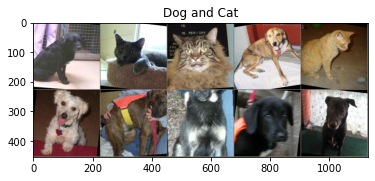

In [4]:
for images,labels in train_loader:
    break
im=make_grid(images,nrow=5)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
print(labels.numpy()[:5])
print(labels.numpy()[5:])
plt.title('Dog and Cat')
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

In [5]:
alex=models.alexnet(pretrained=True).cuda()
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
for param in alex.parameters():
    param.requires_grad=False

In [7]:
alex.classifier=nn.Sequential(nn.Dropout(),
                              nn.Linear(9216,2048),
                              nn.ReLU(),
                              nn.Dropout(),
                              nn.Linear(2048,512),
                              nn.ReLU(),
                              nn.Linear(512,2)).cuda()
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)
 

In [8]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(alex.parameters(),lr=0.001)

In [12]:
import time
start=time.time()
train_losses=[]
test_losses=[]
train_counts=[]
test_counts=[]

max_trn_batch = 800
max_tst_batch = 300

epochs=3
for i in range(epochs):
    i=i+1
    train_count=0
    test_count=0
    for b,(x_train,y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b=b+1
        x_train, y_train = x_train.cuda(), y_train.cuda()
        y_pred=alex(x_train)
        loss=criterion(y_pred,y_train)

        train_count+=(y_pred.argmax(dim=1)==y_train).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b%200 == 0:
            print(f'epoch {i} batch {b} loss {loss}')
    train_losses.append(loss)
    train_counts.append(train_count)
    with torch.no_grad():
        for b,(x_test,y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break
            b=b+1
            x_test, y_test = x_test.cuda(), y_test.cuda()
            y_val=alex(x_test)
            loss=criterion(y_val,y_test).cuda()
            test_count+=(y_val.argmax(dim=1)==y_test).sum()

        test_losses.append(loss)
        test_counts.append(test_count)

end=time.time()
print(f'It takes {end-start} seconds')

epoch 1 batch 200 loss 0.0039338478818535805
epoch 1 batch 400 loss 0.014698652550578117
epoch 1 batch 600 loss 0.07710964977741241
epoch 1 batch 800 loss 0.37729954719543457
epoch 2 batch 200 loss 0.14824123680591583
epoch 2 batch 400 loss 0.1459093987941742
epoch 2 batch 600 loss 0.12066254764795303
epoch 2 batch 800 loss 0.012129717506468296
epoch 3 batch 200 loss 0.06531302630901337
epoch 3 batch 400 loss 0.0002781916409730911
epoch 3 batch 600 loss 0.09735138714313507
epoch 3 batch 800 loss 0.07568156719207764
It takes 111.89448142051697 seconds


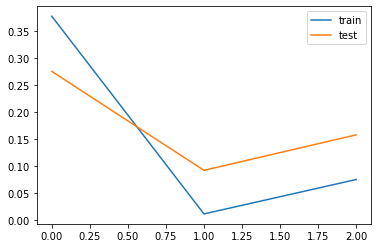

In [31]:
plt.plot(torch.Tensor(train_losses,device='cpu'),label='train')
plt.plot(torch.Tensor(test_losses,device='cpu'),label='test')
plt.legend()
plt.show()

In [33]:
accuracy=test_counts[-1]/3000*100
accuracy.item()

94.66666412353516

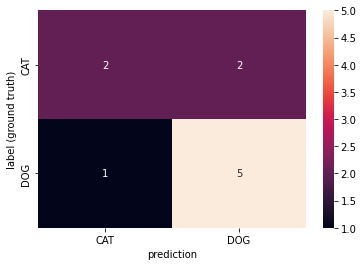

In [39]:
arr=confusion_matrix(torch.tensor(y_test,device='cpu').view(-1),
                     torch.tensor(y_val.argmax(dim=1),device='cpu').view(-1))
df=pd.DataFrame(arr,class_names,class_names)
sn.heatmap(df,annot=True,fmt='d')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [41]:
from PIL import Image
from IPython.display import display

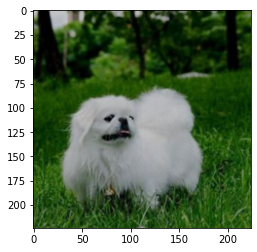

In [51]:
cat=Image.open('dog.jpg')
x=test_transform(cat)
inv=inv_normalize(x)
plt.imshow(np.transpose(inv.numpy(), (1, 2, 0)));

In [52]:
classes=['猫','狗']
with torch.no_grad():
    x=x.view(1,3,224,224)
    x=x.cuda()
    y_val=alex(x)
    index=y_val.argmax(dim=1)

print(f'这是一只{classes[index.item()]}')

这是一只狗
